# Describe data used with model (HETDEX and Stripe 82)

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import mpl_scatter_density
from sklearn.model_selection import train_test_split
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import colorcet as cc
import cmasher as cmr
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

---

## Reading data

#### File name

In [3]:
save_plot_flag      = False
use_imputed         = False

In [4]:
used_area           = 'S82'  # can be 'S82', 'HETDEX'
HETDEX_subset       = 'all'  # 'training', 'test', 'train_test', 'calibration', 'validation', 'known', 'unknown', 'all'
S82_subset          = 'all'  # 'known', 'unknown', 'all'

In [5]:
if use_imputed:
    file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
    imp_string          = '_imputed'
if not use_imputed:
    file_name_dict      = {'S82': gv.file_non_imp_S82, 'HETDEX': gv.file_non_imp_HETDEX, 'COSMOS': gv.file_non_imp_COSMOS}
    imp_string           = '_nonimputed'
file_name               = file_name_dict[used_area]

In [6]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Fint_VLAS82',\
                       'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR',\
                       'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Stotal_TGSS',\
                       'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]
if not use_imputed:
    feats_2_disc_HETDEX.remove('num_imputed')
    feats_2_disc_S82.remove('num_imputed')

In [7]:
full_catalog_HETDEX_df = pd.read_hdf(gv.cat_path + file_name_dict['HETDEX'], key='df').drop(columns=feats_2_disc_HETDEX)
full_catalog_S82_df    = pd.read_hdf(gv.cat_path + file_name_dict['S82'],    key='df').drop(columns=feats_2_disc_S82)

In [8]:
HETDEX_known_filter = np.array(full_catalog_HETDEX_df.loc[: 'is_gal'] == 1) | np.array(full_catalog_HETDEX_df.loc[: 'is_AGN'] == 1)
S82_known_filter    = np.array(full_catalog_S82_df.loc[: 'is_gal'] == 1)    | np.array(full_catalog_S82_df.loc[: 'is_AGN'] == 1)

In [9]:
if HETDEX_subset == 'unknown':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[~HETDEX_known_filter]
elif HETDEX_subset == 'known':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
elif HETDEX_subset == 'training':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    _, full_catalog_HETDEX_df, _, _, _ = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=True)
elif HETDEX_subset == 'test':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    _, _, full_catalog_HETDEX_df, _, _ = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=True)
elif HETDEX_subset == 'train_test':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    full_catalog_HETDEX_df, _, _, _, _ = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=True)
elif HETDEX_subset == 'calibration':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    _, _, _, full_catalog_HETDEX_df, _ = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=True)
elif HETDEX_subset == 'validation':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    _, _, _, _, full_catalog_HETDEX_df = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=True)
else:
    pass

In [10]:
if S82_subset == 'unknown':
    full_catalog_S82_df = full_catalog_S82_df.loc[~S82_known_filter]
elif S82_subset == 'known':
    full_catalog_S82_df = full_catalog_S82_df.loc[S82_known_filter]
else:
    pass

In [11]:
print('Shape of used data in HETDEX')
print('-' * 40)
print(f'Selected sub-set is: {HETDEX_subset}')
print(f'Its shape is:        {full_catalog_HETDEX_df.shape}')
print('-' * 40)
print()

Shape of used data in HETDEX
----------------------------------------
Selected sub-set is: all
Its shape is:        (6729647, 96)
----------------------------------------



In [12]:
print('Shape of used data in Stripe 82')
print('-' * 40)
print(f'Selected sub-set is: {S82_subset}')
print(f'Its shape is:        {full_catalog_S82_df.shape}')
print('-' * 40)
print()

Shape of used data in Stripe 82
----------------------------------------
Selected sub-set is: all
Its shape is:        (369093, 95)
----------------------------------------



---

## Description plots

In [13]:
bands_plot = ['gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag',
              'Hmag', 'Kmag', 'W1mproPM', 'W2mproPM', 'W3mag', 'W4mag']

In [14]:
mag_cols_lim = {'W1mproPM': 20.13, 'W2mproPM': 19.81, 'Sint_LOFAR': 17.52, 'Total_flux_VLASS': 15.21,\
                    'TotalFlux_LoLSS': 12.91, 'Stotal_TGSS': 11.18, 'Fint_VLAS82': 17.86,\
                    'Flux_COSMOSVLA3': 21.25, 'W1mag': 19.6, 'W2mag': 19.34, 'W3mag': 16.67,\
                    'W4mag': 14.62, 'gmag': 23.3, 'rmag': 23.2, 'imag': 23.1, 'zmag': 22.3,\
                    'ymag': 21.4, 'FUVmag': 20.0, 'NUVmag': 21.0, 'FEP': 57.9, 'Jmag': 17.45,\
                    'Hmag': 17.24, 'Kmag': 16.59}  # Proper (5-sigma) limits

for key in mag_cols_lim:
    mag_cols_lim[key] = np.float32(mag_cols_lim[key])

In [15]:
mag_cols_names   = {'W1mproPM': 'W1', 'W2mproPM': 'W2', 'Sint_LOFAR': 'LOFAR', 'Total_flux_VLASS': 'VLASS', 
                  'TotalFlux_LoLSS': 'LoLSS', 'Stotal_TGSS': 'TGSS', 'W1mag': 'W1 (AW)', 
                  'W2mag': 'W2 (AW)', 'W3mag': 'W3', 'W4mag': 'W4', 'gmag': 'g', 'rmag': 'r', 
                  'imag': 'i', 'zmag': 'z', 'ymag': 'y', 'FUVmag': 'FUV', 'NUVmag': 'NUV', 
                  'FEP': 'XMM', 'Jmag': 'J', 'Hmag': 'H', 'Kmag': 'K'}

Plot only for HETDEX sources

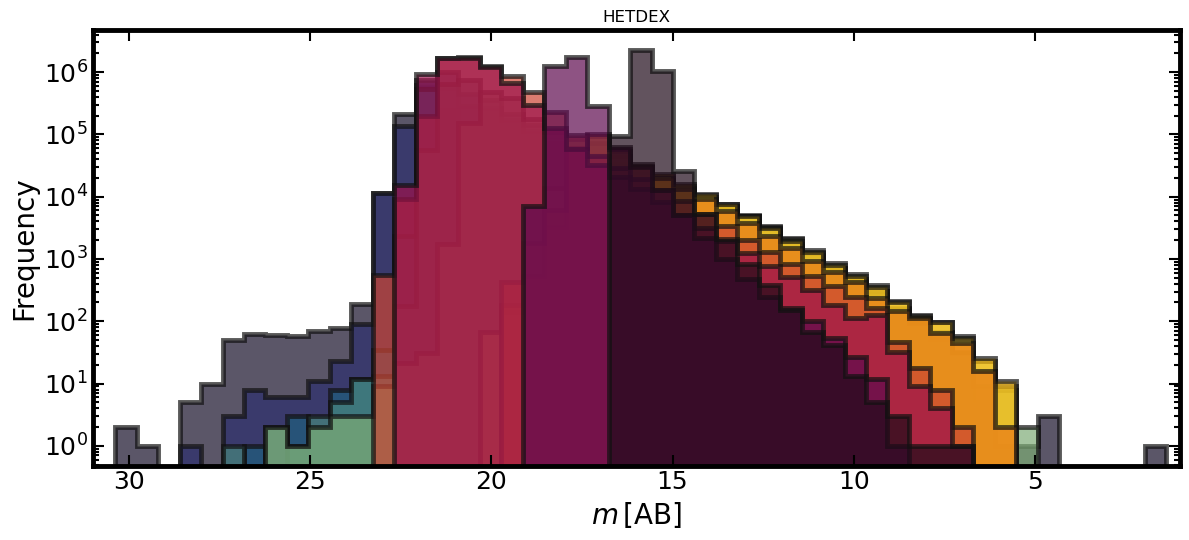

In [16]:
fig             = plt.figure(figsize=(12,5.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_magnitude   = full_catalog_HETDEX_df.loc[:, bands_plot].min().min()
max_magnitude   = full_catalog_HETDEX_df.loc[:, bands_plot].max().max()
mag_bins        = np.linspace(min_magnitude, max_magnitude, 50)

cmap_name       = 'cmr.pride'  # 'cmr.pride', 'cet_CET_R1'

for count, band in enumerate(bands_plot):
    filt_lims = np.array(full_catalog_HETDEX_df.loc[:, band] != mag_cols_lim[band])
    ax1.hist(full_catalog_HETDEX_df.loc[filt_lims, band], bins=mag_bins, histtype='stepfilled',\
             ec='k', lw=3.5, alpha=0.7, fc=plt.get_cmap(gv.cmap_bands, len(bands_plot))(count))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$m\, \mathrm{[AB]}$', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
# plt.legend(loc=1, fontsize=14)
ax1.set_xlim(left=np.floor(min_magnitude), right=np.ceil(max_magnitude))
ax1.invert_xaxis()
ax1.set_title('HETDEX')
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Plot only for Stripe 82 sources

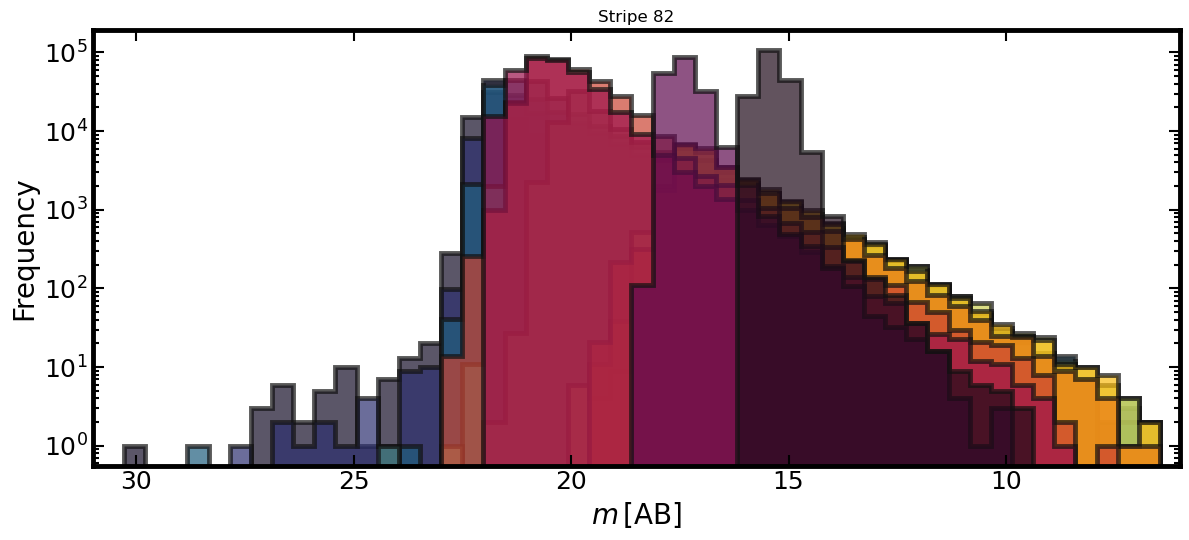

In [17]:
fig             = plt.figure(figsize=(12,5.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_magnitude   = full_catalog_S82_df.loc[:, bands_plot].min().min()
max_magnitude   = full_catalog_S82_df.loc[:, bands_plot].max().max()
mag_bins        = np.linspace(min_magnitude, max_magnitude, 50)

for count, band in enumerate(bands_plot):
    filt_lims = np.array(full_catalog_S82_df.loc[:, band] != mag_cols_lim[band])
    ax1.hist(full_catalog_S82_df.loc[filt_lims, band], bins=mag_bins, histtype='stepfilled',\
             ec='k', lw=3.5, alpha=0.7, fc=plt.get_cmap(gv.cmap_bands, len(bands_plot))(count))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$m\, \mathrm{[AB]}$', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
# plt.legend(loc=1, fontsize=14)
ax1.set_xlim(left=np.floor(min_magnitude), right=np.ceil(max_magnitude))
ax1.invert_xaxis()
ax1.set_title('Stripe 82')
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

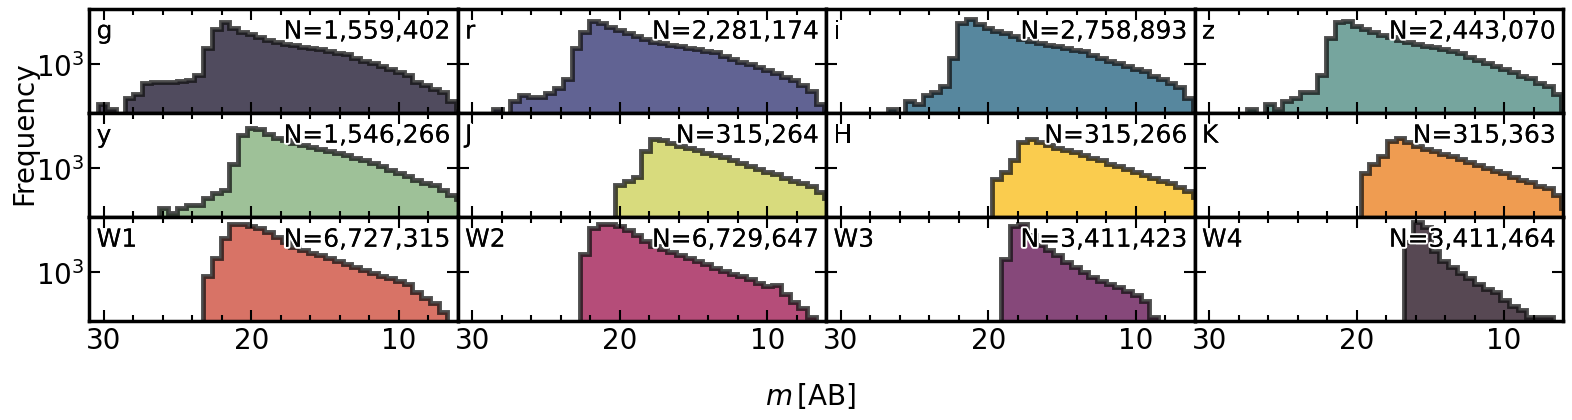

In [18]:
n_cols = 4
n_rows = int(np.ceil((len(bands_plot)) / 4))

min_magnitude_HETDEX  = full_catalog_HETDEX_df.loc[:, bands_plot].min().min()
max_magnitude_HETDEX  = full_catalog_HETDEX_df.loc[:, bands_plot].max().max()
mag_bins_HETDEX       = np.linspace(min_magnitude_HETDEX, max_magnitude_HETDEX, 50)

fig             = plt.figure(figsize=(4 * n_cols, 1.4 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
norm_z          = mcolors.Normalize(vmin=0, vmax=8)

for count, band in enumerate(bands_plot):
    if count == 0:
        axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                     xscale='linear', yscale='log')
    elif count != 0:
        axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                     sharex=axs[0], sharey=axs[0])
    
    filt_lims = np.array(full_catalog_HETDEX_df.loc[:, band] != mag_cols_lim[band]) & np.isfinite(full_catalog_HETDEX_df.loc[:, band])
    axs[count].hist(full_catalog_HETDEX_df.loc[filt_lims, band], bins=mag_bins_HETDEX, histtype='stepfilled',
                    ec='k', lw=3.5, fc=plt.get_cmap(gv.cmap_bands, len(bands_plot))(count),
                    alpha=0.75, label=f'{band}')
    
    axs[count].tick_params(which='both', top=True, right=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=20)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    axs[count].xaxis.set_minor_locator(AutoMinorLocator())
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    #axs[count].grid(zorder=0)
    if count % n_cols != 0:
        plt.setp(axs[count].get_yticklabels(), visible=False)
    # if np.ceil((count + 1) / n_cols) != n_rows:
    #     plt.setp(axs[count].get_xticklabels(), visible=False)
    if count < (len(bands_plot) - n_cols):
        plt.setp(axs[count].get_xticklabels(), visible=False)
    axs[count].annotate(text=f'{mag_cols_names[band]}', xy=(0.02, 0.9),\
                         xycoords='axes fraction', fontsize=18, ha='left', va='top', path_effects=gf.pe2)
    axs[count].annotate(text=f'N={np.sum(filt_lims):,}', xy=(0.98, 0.9),\
                         xycoords='axes fraction', fontsize=18, ha='right', va='top', path_effects=gf.pe2)
    axs[0].set_xlim(left=np.floor(min_magnitude), right=np.ceil(max_magnitude))
    axs[0].invert_xaxis()
    # axs[count].legend(loc=2)


fig.supxlabel('$m\, \mathrm{[AB]}$', fontsize=20, x=0.52)
fig.supylabel('Frequency', fontsize=20, va='bottom')

fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hists_bands_HETDEX_{HETDEX_subset}{imp_string}.pdf', bbox_inches='tight')
plt.show()

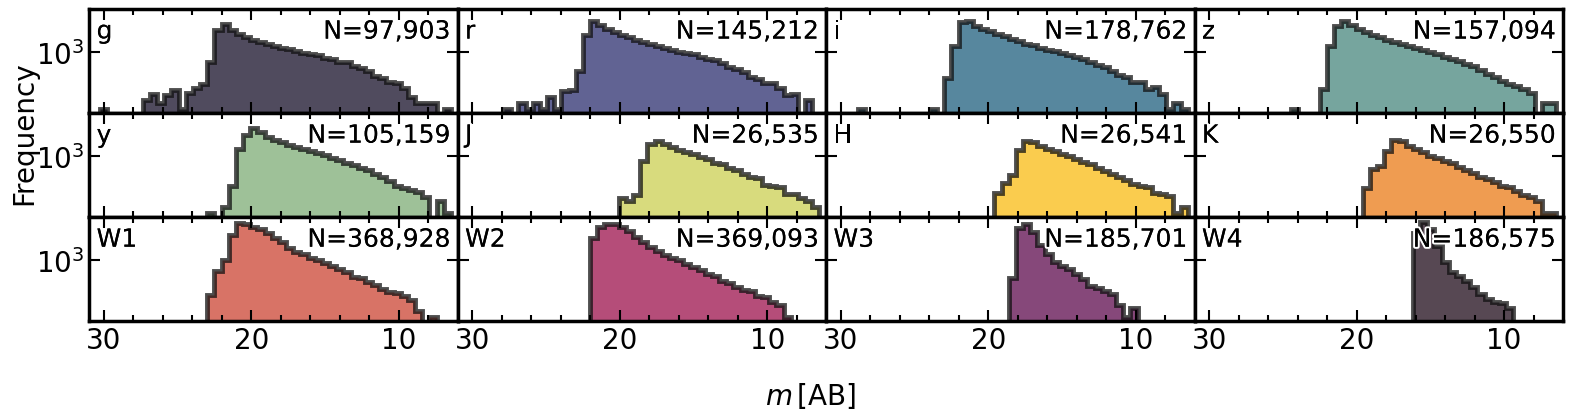

In [19]:
n_cols = 4
n_rows = int(np.ceil((len(bands_plot)) / 4))

min_magnitude_S82  = full_catalog_S82_df.loc[:, bands_plot].min().min()
max_magnitude_S82  = full_catalog_S82_df.loc[:, bands_plot].max().max()
mag_bins_S82       = np.linspace(min_magnitude_S82, max_magnitude_S82, 50)

fig             = plt.figure(figsize=(4 * n_cols, 1.4 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
norm_z          = mcolors.Normalize(vmin=0, vmax=8)

for count, band in enumerate(bands_plot):
    if count == 0:
        axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                     xscale='linear', yscale='log')
    elif count != 0:
        axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                     sharex=axs[0], sharey=axs[0])
    
    filt_lims = np.array(full_catalog_S82_df.loc[:, band] != mag_cols_lim[band]) & np.isfinite(full_catalog_S82_df.loc[:, band])
    axs[count].hist(full_catalog_S82_df.loc[filt_lims, band], bins=mag_bins_S82, histtype='stepfilled',
                    ec='k', lw=3.5, fc=plt.get_cmap(gv.cmap_bands, len(bands_plot))(count),
                    alpha=0.75, label=f'{band}')
    
    axs[count].tick_params(which='both', top=True, right=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=20)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    axs[count].xaxis.set_minor_locator(AutoMinorLocator())
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    #axs[count].grid(zorder=0)
    if count % n_cols != 0:
        plt.setp(axs[count].get_yticklabels(), visible=False)
    # if np.ceil((count + 1) / n_cols) != n_rows:
    #     plt.setp(axs[count].get_xticklabels(), visible=False)
    if count < (len(bands_plot) - n_cols):
        plt.setp(axs[count].get_xticklabels(), visible=False)
    axs[count].annotate(text=f'{mag_cols_names[band]}', xy=(0.02, 0.9),\
                         xycoords='axes fraction', fontsize=18, ha='left', va='top', path_effects=gf.pe2)
    axs[count].annotate(text=f'N={np.sum(filt_lims):,}', xy=(0.98, 0.9),\
                         xycoords='axes fraction', fontsize=18, ha='right', va='top', path_effects=gf.pe2)
    axs[0].set_xlim(left=np.floor(min_magnitude), right=np.ceil(max_magnitude))
    axs[0].invert_xaxis()
    # axs[count].legend(loc=2)


fig.supxlabel('$m\, \mathrm{[AB]}$', fontsize=20, x=0.52)
fig.supylabel('Frequency', fontsize=20, va='bottom')

fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hists_bands_S82_{S82_subset}{imp_string}.pdf', bbox_inches='tight')
plt.show()

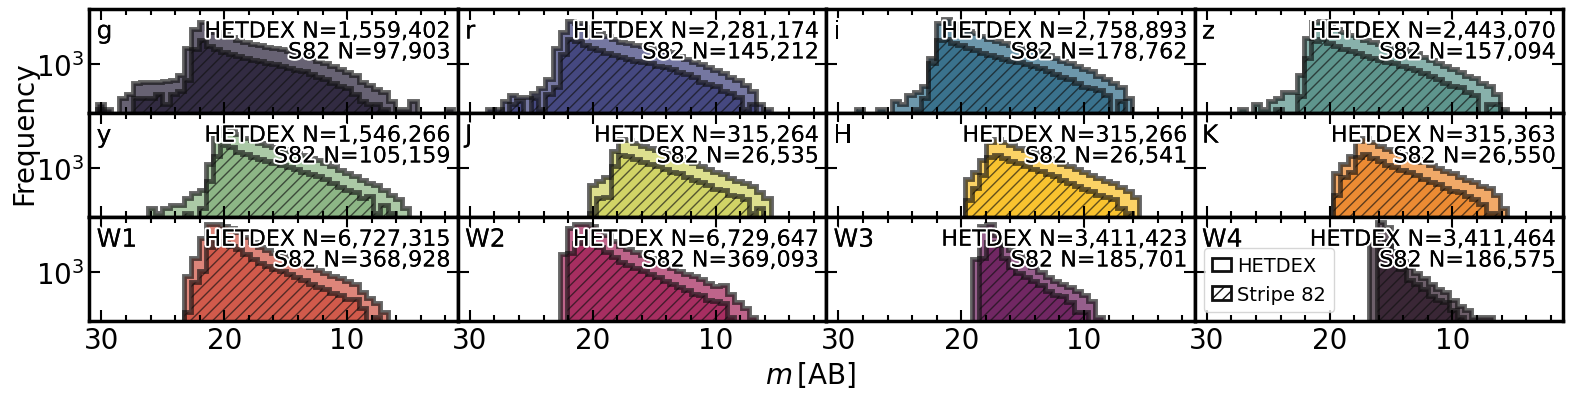

In [20]:
n_cols = 4
n_rows = int(np.ceil((len(bands_plot)) / 4))

min_magnitude  = np.nanmin([min_magnitude_HETDEX, min_magnitude_S82])
max_magnitude  = np.nanmax([max_magnitude_HETDEX, max_magnitude_S82])
mag_bins_both  = np.linspace(min_magnitude, max_magnitude, 50)

fig             = plt.figure(figsize=(4 * n_cols, 1.4 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
norm_z          = mcolors.Normalize(vmin=0, vmax=8)

for count, band in enumerate(bands_plot):
    if count == 0:
        axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                     xscale='linear', yscale='log')
    elif count != 0:
        axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                     sharex=axs[0], sharey=axs[0])
    
    filt_lims_HETDEX = np.array(full_catalog_HETDEX_df.loc[:, band] != mag_cols_lim[band]) & np.isfinite(full_catalog_HETDEX_df.loc[:, band])
    filt_lims_S82    = np.array(full_catalog_S82_df.loc[:, band] != mag_cols_lim[band]) & np.isfinite(full_catalog_S82_df.loc[:, band])
    # filt_lims_HETDEX = np.ones_like(full_catalog_HETDEX_df.loc[:, 'is_AGN'])
    # filt_lims_S82    = np.ones_like(full_catalog_S82_df.loc[:, 'is_AGN'])
    axs[count].hist(full_catalog_HETDEX_df.loc[filt_lims_HETDEX, band], bins=mag_bins_both, histtype='stepfilled',
                    ec='k', lw=3.5, fc=plt.get_cmap(gv.cmap_bands, len(bands_plot))(count),
                    alpha=0.65, label=f'{band}')
    axs[count].hist(full_catalog_S82_df.loc[filt_lims_S82, band], bins=mag_bins_both, histtype='stepfilled',
                    ec='k', lw=3.5, fc=plt.get_cmap(gv.cmap_bands, len(bands_plot))(count),
                    alpha=0.65, label=f'{band}', hatch='///')
    
    axs[count].tick_params(which='both', top=True, right=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=20)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    axs[count].xaxis.set_minor_locator(AutoMinorLocator())
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    #axs[count].grid(zorder=0)
    if count % n_cols != 0:
        plt.setp(axs[count].get_yticklabels(), visible=False)
    # if np.ceil((count + 1) / n_cols) != n_rows:
    #     plt.setp(axs[count].get_xticklabels(), visible=False)
    if count < (len(bands_plot) - n_cols):
        plt.setp(axs[count].get_xticklabels(), visible=False)
    axs[count].annotate(text=f'{mag_cols_names[band]}', xy=(0.02, 0.9),\
                         xycoords='axes fraction', fontsize=18, ha='left', va='top', path_effects=gf.pe2)
    axs[count].annotate(text=f'HETDEX N={np.sum(filt_lims_HETDEX):,}', xy=(0.98, 0.9),\
                         xycoords='axes fraction', fontsize=16, ha='right', va='top', path_effects=gf.pe2)
    axs[count].annotate(text=f'S82 N={np.sum(filt_lims_S82):,}', xy=(0.98, 0.7),\
                         xycoords='axes fraction', fontsize=16, ha='right', va='top', path_effects=gf.pe2)
    axs[0].set_xlim(left=np.floor(min_magnitude), right=np.ceil(max_magnitude))
    axs[0].invert_xaxis()
    # axs[count].legend(loc=2)
HETDEX_patch = mpatches.Patch(fc='None', ec='k', label='HETDEX', lw=2.0)
S82_patch    = mpatches.Patch(fc='None', ec='k', label='Stripe 82', hatch='///', lw=2.0)
axs[len(bands_plot) - 1].legend(handles=[HETDEX_patch, S82_patch], loc=3, fontsize=14,\
               handletextpad=0.3, handlelength=1.0)

fig.supxlabel('$m\, \mathrm{[AB]}$', fontsize=20, x=0.52, y=0.06)
fig.supylabel('Frequency', fontsize=20, va='bottom')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hists_bands_HETDEX_{HETDEX_subset}_S82_{S82_subset}{imp_string}.pdf', bbox_inches='tight')
plt.show()

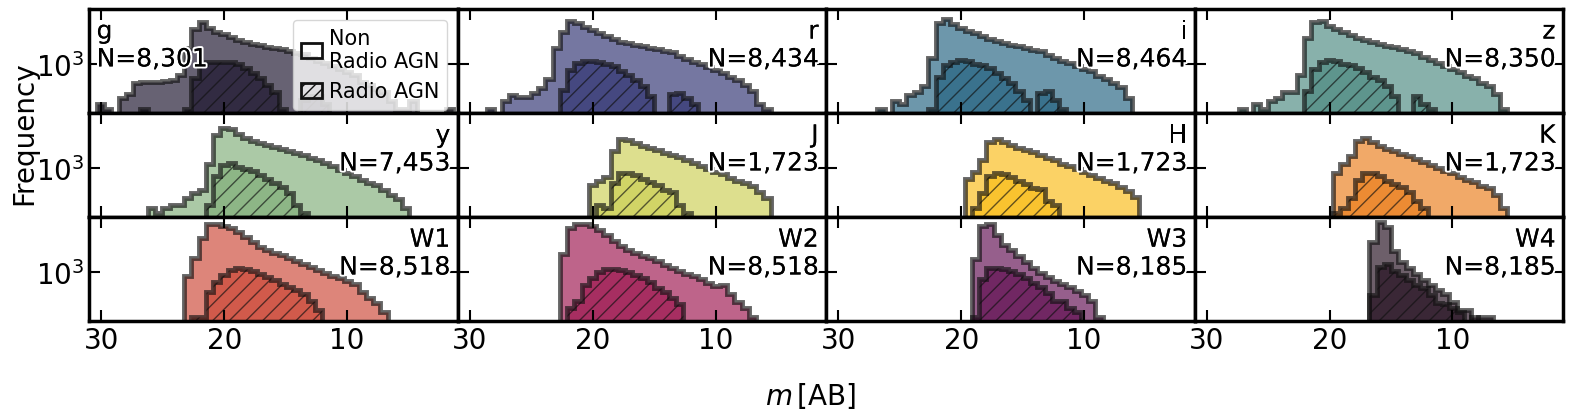

In [21]:
n_cols = 4
n_rows = int(np.ceil((len(bands_plot)) / 4))

min_magnitude_HETDEX  = full_catalog_HETDEX_df.loc[:, bands_plot].min().min()
max_magnitude_HETDEX  = full_catalog_HETDEX_df.loc[:, bands_plot].max().max()
mag_bins_HETDEX       = np.linspace(min_magnitude_HETDEX, max_magnitude_HETDEX, 50)

fig             = plt.figure(figsize=(4 * n_cols, 1.4 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
norm_z          = mcolors.Normalize(vmin=0, vmax=8)

for count, band in enumerate(bands_plot):
    if count == 0:
        axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                     xscale='linear', yscale='log')
    elif count != 0:
        axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                     sharex=axs[0], sharey=axs[0])
    # used_cols  = unique_cols_imp.index[count:]
    # print(used_cols)
    # print(new_band)
    
    if use_imputed:
        filt_lims      = np.array(full_catalog_HETDEX_df.loc[:, band] != mag_cols_lim[band])
    if not use_imputed:
        filt_lims      = np.isfinite(full_catalog_HETDEX_df.loc[:, band])
    filt_radio_agn = np.array(full_catalog_HETDEX_df.loc[:, 'radio_detect'] == 1) & np.array(full_catalog_HETDEX_df.loc[:, 'is_AGN'] == 1)
    axs[count].hist(full_catalog_HETDEX_df.loc[filt_lims & ~filt_radio_agn, band], bins=mag_bins_HETDEX, histtype='stepfilled',
                    ec='k', lw=3.5, fc=plt.get_cmap(gv.cmap_bands, len(bands_plot))(count),
                    alpha=0.65, label=f'{band}')
    axs[count].hist(full_catalog_HETDEX_df.loc[filt_lims & filt_radio_agn, band], bins=mag_bins_HETDEX, histtype='stepfilled',
                    ec='k', lw=3.5, fc=plt.get_cmap(gv.cmap_bands, len(bands_plot))(count),
                    alpha=0.65, label=f'{band}', hatch='//')
    axs[count].tick_params(which='both', top=True, right=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=20)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    #axs[count].grid(zorder=0)
    if count % n_cols != 0:
        plt.setp(axs[count].get_yticklabels(), visible=False)
    if count < (len(bands_plot) - n_cols):
        plt.setp(axs[count].get_xticklabels(), visible=False)
    if count == 0:
        axs[count].annotate(text=f'{mag_cols_names[band]}\nN={np.sum(filt_lims & filt_radio_agn):,}', xy=(0.02, 0.9),\
                             xycoords='axes fraction', fontsize=18, ha='left', va='top', path_effects=gf.pe2)
    if count != 0:
        axs[count].annotate(text=f'{mag_cols_names[band]}\nN={np.sum(filt_lims & filt_radio_agn):,}', xy=(0.98, 0.9),\
                             xycoords='axes fraction', fontsize=18, ha='right', va='top', path_effects=gf.pe2)
axs[0].set_xlim(left=np.floor(min_magnitude), right=np.ceil(max_magnitude))
axs[0].invert_xaxis()

radio_AGN_patch     = mpatches.Patch(fc='None', ec='k', label='Non\nRadio AGN', lw=2.0)
non_radio_AGN_patch = mpatches.Patch(fc='None', ec='k', label='Radio AGN', hatch='///', lw=2.0)
axs[0].legend(handles=[radio_AGN_patch, non_radio_AGN_patch], loc=1, fontsize=15,
              handletextpad=0.3, handlelength=1.0)

fig.supxlabel('$m\, \mathrm{[AB]}$', fontsize=20, x=0.52)
fig.supylabel('Frequency', fontsize=20, va='bottom')

fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hists_bands_radio_AGN_HETDEX_{HETDEX_subset}{imp_string}.pdf', bbox_inches='tight')
plt.show()

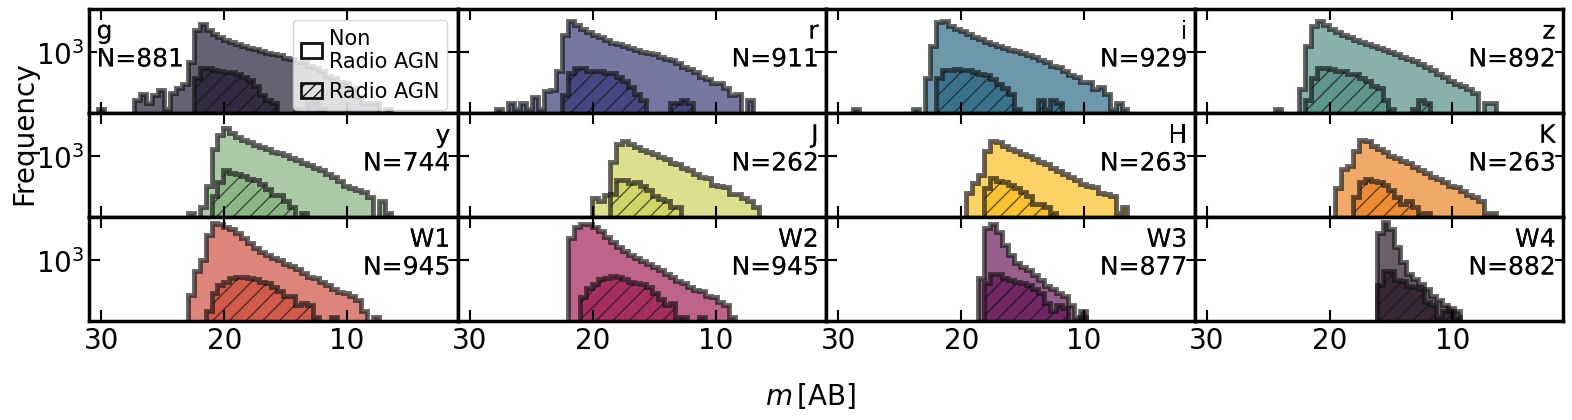

In [22]:
n_cols = 4
n_rows = int(np.ceil((len(bands_plot)) / 4))

min_magnitude_S82  = full_catalog_S82_df.loc[:, bands_plot].min().min()
max_magnitude_S82  = full_catalog_S82_df.loc[:, bands_plot].max().max()
mag_bins_S82       = np.linspace(min_magnitude_S82, max_magnitude_S82, 50)

fig             = plt.figure(figsize=(4 * n_cols, 1.4 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
norm_z          = mcolors.Normalize(vmin=0, vmax=8)

for count, band in enumerate(bands_plot):
    if count == 0:
        axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                     xscale='linear', yscale='log')
    elif count != 0:
        axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                     sharex=axs[0], sharey=axs[0])
    # used_cols  = unique_cols_imp.index[count:]
    # print(used_cols)
    # print(new_band)
    
    filt_lims      = np.array(full_catalog_S82_df.loc[:, band] != mag_cols_lim[band]) & np.isfinite(full_catalog_S82_df.loc[:, band])
    filt_radio_agn = np.array(full_catalog_S82_df.loc[:, 'radio_detect'] == 1) & np.array(full_catalog_S82_df.loc[:, 'is_AGN'] == 1)
    axs[count].hist(full_catalog_S82_df.loc[filt_lims & ~filt_radio_agn, band], bins=mag_bins_S82, histtype='stepfilled',
                    ec='k', lw=3.5, fc=plt.get_cmap(gv.cmap_bands, len(bands_plot))(count),
                    alpha=0.65, label=f'{band}')
    axs[count].hist(full_catalog_S82_df.loc[filt_lims & filt_radio_agn, band], bins=mag_bins_S82, histtype='stepfilled',
                    ec='k', lw=3.5, fc=plt.get_cmap(gv.cmap_bands, len(bands_plot))(count),
                    alpha=0.65, label=f'{band}', hatch='//')
    axs[count].tick_params(which='both', top=True, right=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=20)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    #axs[count].grid(zorder=0)
    if count % n_cols != 0:
        plt.setp(axs[count].get_yticklabels(), visible=False)
    if count < (len(bands_plot) - n_cols):
        plt.setp(axs[count].get_xticklabels(), visible=False)
    if count == 0:
        axs[count].annotate(text=f'{mag_cols_names[band]}\nN={np.sum(filt_lims & filt_radio_agn):,}', xy=(0.02, 0.9),\
                             xycoords='axes fraction', fontsize=18, ha='left', va='top', path_effects=gf.pe2)
    if count != 0:
        axs[count].annotate(text=f'{mag_cols_names[band]}\nN={np.sum(filt_lims & filt_radio_agn):,}', xy=(0.98, 0.9),\
                             xycoords='axes fraction', fontsize=18, ha='right', va='top', path_effects=gf.pe2)
axs[0].set_xlim(left=np.floor(min_magnitude), right=np.ceil(max_magnitude))
axs[0].invert_xaxis()

radio_AGN_patch     = mpatches.Patch(fc='None', ec='k', label='Non\nRadio AGN', lw=2.0)
non_radio_AGN_patch = mpatches.Patch(fc='None', ec='k', label='Radio AGN', hatch='///', lw=2.0)
axs[0].legend(handles=[radio_AGN_patch, non_radio_AGN_patch], loc=1, fontsize=15,
              handletextpad=0.3, handlelength=1.0)

fig.supxlabel('$m\, \mathrm{[AB]}$', fontsize=20, x=0.52)
fig.supylabel('Frequency', fontsize=20, va='bottom')

fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hists_bands_radio_AGN_S82_{S82_subset}{imp_string}.pdf', bbox_inches='tight')
plt.show()

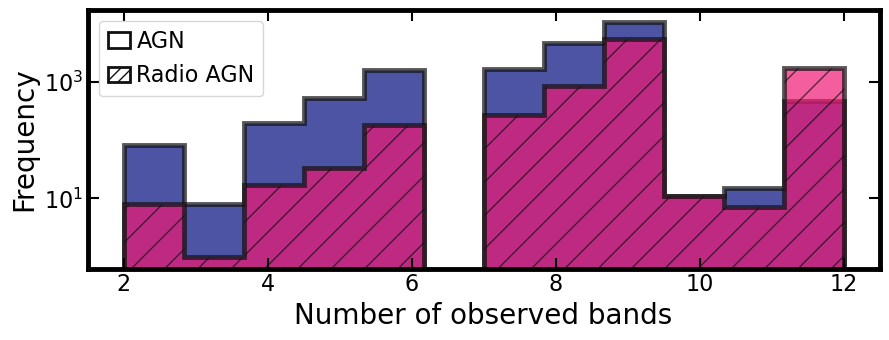

In [23]:
fig             = plt.figure(figsize=(9,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

filt_AGN_HETDEX        = np.array(full_catalog_HETDEX_df.loc[:, 'is_AGN'] == 1)
filt_nrad_AGN_HETDEX   = np.array(full_catalog_HETDEX_df.loc[:, 'radio_detect'] == 0) & np.array(full_catalog_HETDEX_df.loc[:, 'is_AGN'] == 1)
filt_radio_AGN_HETDEX  = np.array(full_catalog_HETDEX_df.loc[:, 'radio_detect'] == 1) & np.array(full_catalog_HETDEX_df.loc[:, 'is_AGN'] == 1)

min_num_band_HETDEX   = full_catalog_HETDEX_df.loc[:, 'band_num'].min()
max_num_band_HETDEX   = full_catalog_HETDEX_df.loc[:, 'band_num'].max()
band_bins_HETDEX      = np.linspace(min_num_band_HETDEX, max_num_band_HETDEX, 13)

_, bins, _ = ax1.hist(full_catalog_HETDEX_df.loc[filt_nrad_AGN_HETDEX, 'band_num'], bins=band_bins_HETDEX, histtype='stepfilled', ec='k',
                      fc=plt.get_cmap('cet_bmy',3)(0.0), lw=3.5, label='Non radio AGN', alpha=0.7, density=False)
ax1.hist(full_catalog_HETDEX_df.loc[filt_radio_AGN_HETDEX, 'band_num'], bins=band_bins_HETDEX, histtype='stepfilled', ec='k',
         fc=plt.get_cmap('cet_bmy',3)(0.5), lw=3.5, label='Radio AGN', alpha=0.7, density=False, hatch='/')

AGN_patch       = mpatches.Patch(fc='None', ec='k', label='AGN', lw=2.0)
radio_AGN_patch = mpatches.Patch(fc='None', ec='k', label='Radio AGN', hatch='///', lw=2.0)
ax1.legend(handles=[AGN_patch, radio_AGN_patch], loc=2, fontsize=16,
              handletextpad=0.3, handlelength=1.0)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Number of observed bands', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_nbands_rAGN_non_rAGN_HETDEX_{HETDEX_subset}{imp_string}.pdf', bbox_inches='tight')
plt.show()

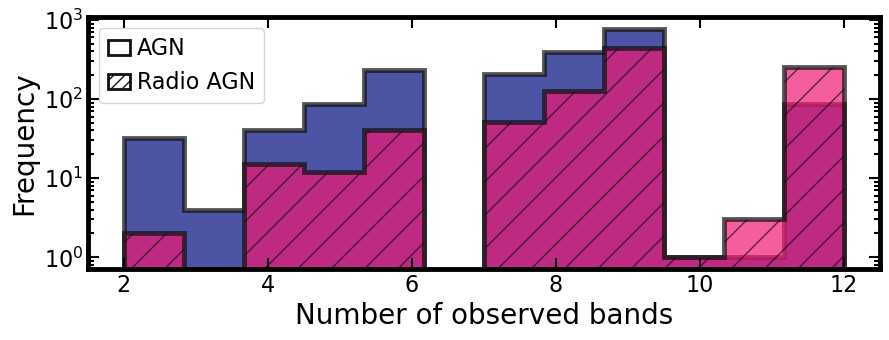

In [24]:
fig             = plt.figure(figsize=(9,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

filt_AGN_S82        = np.array(full_catalog_S82_df.loc[:, 'is_AGN'] == 1)
filt_nrad_AGN_S82   = np.array(full_catalog_S82_df.loc[:, 'radio_detect'] == 0) & np.array(full_catalog_S82_df.loc[:, 'is_AGN'] == 1)
filt_radio_AGN_S82  = np.array(full_catalog_S82_df.loc[:, 'radio_detect'] == 1) & np.array(full_catalog_S82_df.loc[:, 'is_AGN'] == 1)

min_num_band_S82   = full_catalog_S82_df.loc[:, 'band_num'].min()
max_num_band_S82   = full_catalog_S82_df.loc[:, 'band_num'].max()
band_bins_S82      = np.linspace(min_num_band_S82, max_num_band_S82, 13)

_, bins, _ = ax1.hist(full_catalog_S82_df.loc[filt_nrad_AGN_S82, 'band_num'], bins=band_bins_S82, histtype='stepfilled', ec='k',
                      fc=plt.get_cmap('cet_bmy',3)(0.0), lw=3.5, label='Non radio AGN', alpha=0.7, density=False)
ax1.hist(full_catalog_S82_df.loc[filt_radio_AGN_S82, 'band_num'], bins=band_bins_S82, histtype='stepfilled', ec='k',
         fc=plt.get_cmap('cet_bmy',3)(0.5), lw=3.5, label='Radio AGN', alpha=0.7, density=False, hatch='/')

AGN_patch       = mpatches.Patch(fc='None', ec='k', label='AGN', lw=2.0)
radio_AGN_patch = mpatches.Patch(fc='None', ec='k', label='Radio AGN', hatch='///', lw=2.0)
ax1.legend(handles=[AGN_patch, radio_AGN_patch], loc=2, fontsize=16,
              handletextpad=0.3, handlelength=1.0)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Number of observed bands', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_nbands_rAGN_non_rAGN_S82_{S82_subset}{imp_string}.pdf', bbox_inches='tight')
plt.show()

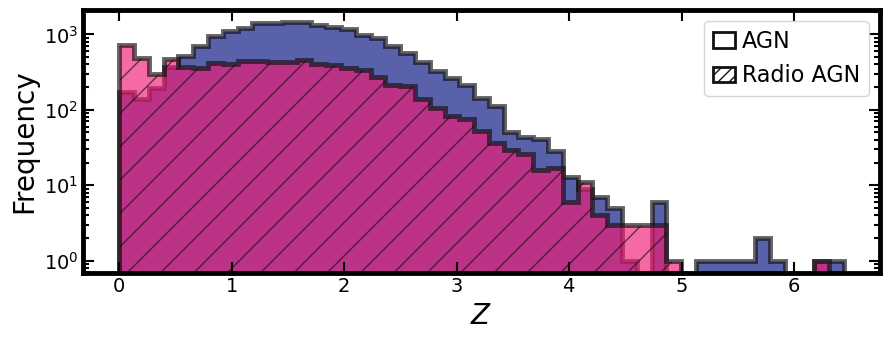

In [25]:
fig             = plt.figure(figsize=(9,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')


filt_AGN_HETDEX        = np.array(full_catalog_HETDEX_df.loc[:, 'is_AGN'] == 1)
filt_nrad_AGN_HETDEX   = np.array(full_catalog_HETDEX_df.loc[:, 'radio_detect'] == 0) & np.array(full_catalog_HETDEX_df.loc[:, 'is_AGN'] == 1)
filt_radio_AGN_HETDEX  = np.array(full_catalog_HETDEX_df.loc[:, 'radio_detect'] == 1) & np.array(full_catalog_HETDEX_df.loc[:, 'is_AGN'] == 1)

min_z_HETDEX           = full_catalog_HETDEX_df.loc[:, 'Z'].min()
max_z_HETDEX           = full_catalog_HETDEX_df.loc[:, 'Z'].max()
z_bins_HETDEX          = np.linspace(min_z_HETDEX, max_z_HETDEX, 50)

_, bins, _ = ax1.hist(full_catalog_HETDEX_df.loc[filt_nrad_AGN_HETDEX, 'Z'], bins=z_bins_HETDEX, histtype='stepfilled', ec='k',
                      fc=plt.get_cmap('cet_bmy',3)(0.0), lw=3.5, label='AGN', alpha=0.65, density=False)
ax1.hist(full_catalog_HETDEX_df.loc[filt_radio_AGN_HETDEX, 'Z'], bins=z_bins_HETDEX, histtype='stepfilled', ec='k',
         fc=plt.get_cmap('cet_bmy',3)(0.5), lw=3.5, label='Radio AGN', alpha=0.65, density=False, hatch='/')

AGN_patch       = mpatches.Patch(fc='None', ec='k', label='AGN', lw=2.0)
radio_AGN_patch = mpatches.Patch(fc='None', ec='k', label='Radio AGN', hatch='///', lw=2.0)
ax1.legend(handles=[AGN_patch, radio_AGN_patch], loc=1, fontsize=16,
              handletextpad=0.3, handlelength=1.0)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$Z$', size=20)
# ax1.set_ylabel('Normalised\nFrequency', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
# plt.legend(loc=1, fontsize=14)
# ax1.set_xlim(left=2.8, right=20.2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_z_radio_non_radio_AGN_HETDEX_{HETDEX_subset}{imp_string}.pdf', bbox_inches='tight')
plt.show()

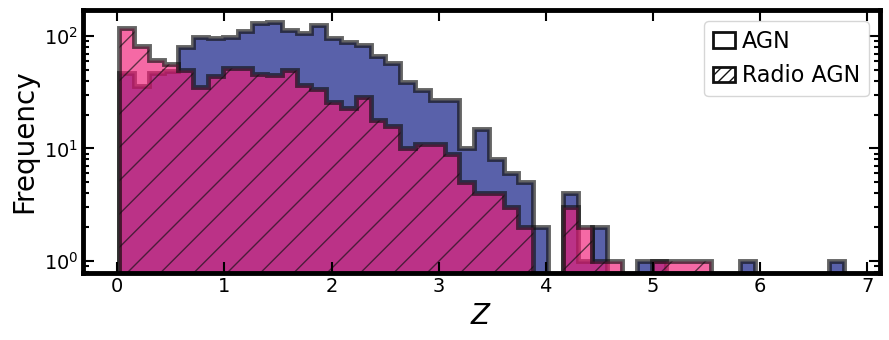

In [26]:
fig             = plt.figure(figsize=(9,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')


filt_AGN_S82        = np.array(full_catalog_S82_df.loc[:, 'is_AGN'] == 1)
filt_nrad_AGN_S82   = np.array(full_catalog_S82_df.loc[:, 'radio_detect'] == 0) & np.array(full_catalog_S82_df.loc[:, 'is_AGN'] == 1)
filt_radio_AGN_S82  = np.array(full_catalog_S82_df.loc[:, 'radio_detect'] == 1) & np.array(full_catalog_S82_df.loc[:, 'is_AGN'] == 1)

min_z_S82           = full_catalog_S82_df.loc[:, 'Z'].min()
max_z_S82           = full_catalog_S82_df.loc[:, 'Z'].max()
z_bins_S82          = np.linspace(min_z_S82, max_z_S82, 50)

_, bins, _ = ax1.hist(full_catalog_S82_df.loc[filt_nrad_AGN_S82, 'Z'], bins=z_bins_S82, histtype='stepfilled', ec='k',
                      fc=plt.get_cmap('cet_bmy',3)(0.0), lw=3.5, label='AGN', alpha=0.65, density=False)
ax1.hist(full_catalog_S82_df.loc[filt_radio_AGN_S82, 'Z'], bins=z_bins_S82, histtype='stepfilled', ec='k',
         fc=plt.get_cmap('cet_bmy',3)(0.5), lw=3.5, label='Radio AGN', alpha=0.65, density=False, hatch='/')

AGN_patch       = mpatches.Patch(fc='None', ec='k', label='AGN', lw=2.0)
radio_AGN_patch = mpatches.Patch(fc='None', ec='k', label='Radio AGN', hatch='///', lw=2.0)
ax1.legend(handles=[AGN_patch, radio_AGN_patch], loc=1, fontsize=16,
              handletextpad=0.3, handlelength=1.0)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$Z$', size=20)
# ax1.set_ylabel('Normalised\nFrequency', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
# plt.legend(loc=1, fontsize=14)
# ax1.set_xlim(left=2.8, right=20.2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_z_radio_non_radio_AGN_S82_{S82_subset}{imp_string}.pdf', bbox_inches='tight')
plt.show()

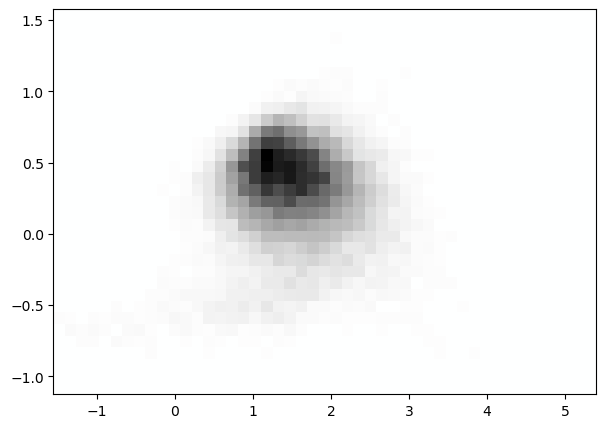

In [27]:
fig_temp             = plt.figure(figsize=(7,5))
ax1_temp             = fig_temp.add_subplot(111, xscale='linear', yscale='linear',  projection='scatter_density')

if use_imputed:
    filt_plot_HETDEX = np.array(full_catalog_HETDEX_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                       np.array(full_catalog_HETDEX_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                       np.array(full_catalog_HETDEX_df.loc[:, 'W3mag']    != mag_cols_lim['W3mag'])
if not use_imputed:
    filt_plot_HETDEX = np.isfinite(full_catalog_HETDEX_df.loc[:, 'W1mproPM']) &\
                       np.isfinite(full_catalog_HETDEX_df.loc[:, 'W2mproPM']) &\
                       np.isfinite(full_catalog_HETDEX_df.loc[:, 'W3mag'])

filt_agn_HETDEX      = np.array(full_catalog_HETDEX_df.loc[:, 'is_AGN'] == 1)

if np.sum(filt_agn_HETDEX & filt_plot_HETDEX) > 0:
    dens_agn_HETDEX  = ax1_temp.scatter_density((full_catalog_HETDEX_df.loc[filt_agn_HETDEX & filt_plot_HETDEX, 'W2mproPM'] -\
                                                 full_catalog_HETDEX_df.loc[filt_agn_HETDEX & filt_plot_HETDEX, 'W3mag']),\
                                                (full_catalog_HETDEX_df.loc[filt_agn_HETDEX & filt_plot_HETDEX, 'W1mproPM'] -\
                                                 full_catalog_HETDEX_df.loc[filt_agn_HETDEX & filt_plot_HETDEX, 'W2mproPM']),\
                                                 cmap=plt.get_cmap('cet_gray_r'), zorder=0, dpi=10, alpha=1.0)

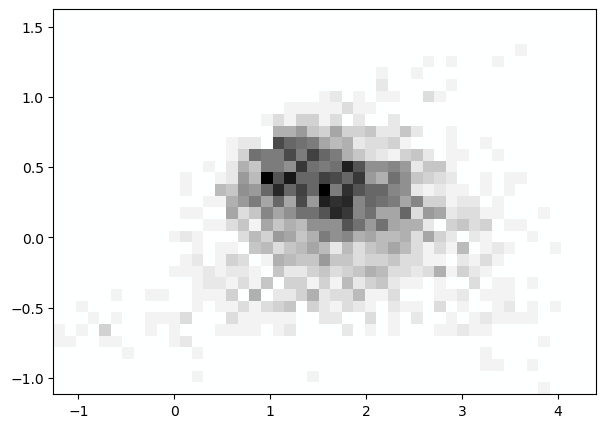

In [28]:
fig_temp             = plt.figure(figsize=(7,5))
ax1_temp             = fig_temp.add_subplot(111, xscale='linear', yscale='linear',  projection='scatter_density')

if use_imputed:
    filt_plot_S82 = np.array(full_catalog_S82_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                    np.array(full_catalog_S82_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                    np.array(full_catalog_S82_df.loc[:, 'W3mag']    != mag_cols_lim['W3mag'])
if not use_imputed:
    filt_plot_S82 = np.isfinite(full_catalog_S82_df.loc[:, 'W1mproPM']) &\
                    np.isfinite(full_catalog_S82_df.loc[:, 'W2mproPM']) &\
                    np.isfinite(full_catalog_S82_df.loc[:, 'W3mag'])
filt_agn_S82  = np.array(full_catalog_S82_df.loc[:, 'is_AGN'] == 1)

if np.sum(filt_agn_S82 & filt_plot_S82) > 0:
    dens_agn_S82  = ax1_temp.scatter_density((full_catalog_S82_df.loc[filt_agn_S82 & filt_plot_S82, 'W2mproPM'] -\
                                              full_catalog_S82_df.loc[filt_agn_S82 & filt_plot_S82, 'W3mag']),\
                                             (full_catalog_S82_df.loc[filt_agn_S82 & filt_plot_S82, 'W1mproPM'] -\
                                              full_catalog_S82_df.loc[filt_agn_S82 & filt_plot_S82, 'W2mproPM']),\
                                              cmap=plt.get_cmap('cet_gray_r'), zorder=0, dpi=10, alpha=1.0)

In [29]:
num_contour_levels = 10
type_of_levels     = 'log'  # 'log', 'linear'

In [30]:
print('For the following plot, HETDEX contour levels will be located at:')
if type_of_levels  == 'linear':
    tmp_levs_HETDEX = np.linspace(0.5, 10**(np.log10(np.nanmax(dens_agn_HETDEX.get_array()))), num_contour_levels)
if type_of_levels  == 'log':
    tmp_levs_HETDEX = np.logspace(np.log10(0.5), np.log10(np.nanmax(dens_agn_HETDEX.get_array())), num_contour_levels)
tmp_levs_HETDEX = np.ceil(tmp_levs_HETDEX)
tmp_levs_HETDEX[num_contour_levels - 1] -= tmp_levs_HETDEX[num_contour_levels - 1] % 10**np.floor(np.log10(tmp_levs_HETDEX[num_contour_levels - 1]))
print(tmp_levs_HETDEX)

For the following plot, HETDEX contour levels will be located at:
[  1.   2.   3.   5.  10.  20.  42.  87. 181. 300.]


In [31]:
print('For the following plot, S82 contour levels will be located at:')
if type_of_levels  == 'linear':
    tmp_levs_S82 = np.linspace(0.5, 10**(np.log10(np.nanmax(dens_agn_S82.get_array()))), num_contour_levels)
if type_of_levels  == 'log':
    tmp_levs_S82 = np.logspace(np.log10(0.5), np.log10(np.nanmax(dens_agn_S82.get_array())), num_contour_levels)
tmp_levs_S82 = np.ceil(tmp_levs_S82)
tmp_levs_S82[num_contour_levels - 1] -= tmp_levs_S82[num_contour_levels - 1] % 10**np.floor(np.log10(tmp_levs_S82[num_contour_levels - 1]))
print(tmp_levs_S82)

For the following plot, S82 contour levels will be located at:
[ 1.  1.  2.  2.  3.  5.  7. 11. 17. 20.]


In [32]:
dens_clb_in = True  # Plot colorbar for density outside of inside axes.

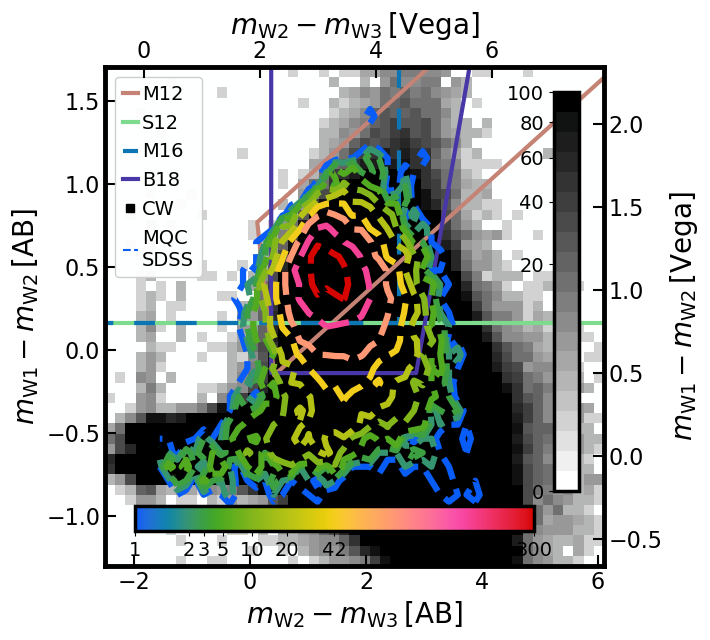

In [33]:
if not dens_clb_in:
    fig                = plt.figure(figsize=(9,6.5))
if dens_clb_in:
    fig                = plt.figure(figsize=(7.2,6.5))
ax1                = fig.add_subplot(111, xscale='linear', yscale='linear', projection='scatter_density')

num_levels_dens    = 20
cmap_dens          = 'cet_gray_r'
cmap_cont          = 'cet_CET_R3'
cmap_agn           = 'cet_CET_C9'

if np.sum(filt_agn_HETDEX & filt_plot_HETDEX) > 0:
    if type_of_levels  == 'linear':
        contour_levels_HETDEX = np.linspace(0.5, 10**(np.log10(np.nanmax(dens_agn_HETDEX.get_array()))),\
                                            num_contour_levels)
    if type_of_levels  == 'log':
        contour_levels_HETDEX = np.logspace(np.log10(0.5),  np.log10(np.nanmax(dens_agn_HETDEX.get_array())),\
                                            num_contour_levels)
    contour_levels_HETDEX[num_contour_levels - 1] -= contour_levels_HETDEX[num_contour_levels - 1] %\
                                                    10**np.floor(np.log10(contour_levels_HETDEX[num_contour_levels - 1]))
    contour_levels_HETDEX = np.unique(np.ceil(contour_levels_HETDEX))
    
AB_lims_x          = (-2.5, 6.1)
AB_lims_y          = (-1.3, 1.7)

num_levels_dens = 20
cmap_dens = 'cet_gray_r'
cmap_cont = 'cet_CET_R3'
cmap_agn  = 'cet_CET_C9'

norm_val  = mcolors.CenteredNorm(vcenter=0.5)
norm_dens = ImageNormalize(vmin=0, vmax=100, stretch=PowerStretch(0.35))

if np.sum(filt_agn_HETDEX & filt_plot_HETDEX) > 0:
    norm_cont      = ImageNormalize(vmin=contour_levels_HETDEX[0], vmax=contour_levels_HETDEX[-1], stretch=PowerStretch(0.35))

filt_bands         = np.array(full_catalog_HETDEX_df.loc[:, 'W1mproPM']  != mag_cols_lim['W1mproPM']) &\
                     np.array(full_catalog_HETDEX_df.loc[:, 'W2mproPM']  != mag_cols_lim['W2mproPM']) &\
                     np.array(full_catalog_HETDEX_df.loc[:, 'W3mag']     != mag_cols_lim['W3mag'])

filt_plot          = np.isfinite(full_catalog_HETDEX_df.loc[:, 'W2mproPM'] - full_catalog_HETDEX_df.loc[:, 'W3mag']) &\
                     np.isfinite(full_catalog_HETDEX_df.loc[:, 'W1mproPM'] - full_catalog_HETDEX_df.loc[:, 'W2mproPM'])

dens_plot_data_x = (full_catalog_HETDEX_df.loc[filt_bands, 'W2mproPM'] -\
                    full_catalog_HETDEX_df.loc[filt_bands, 'W3mag'])[filt_plot]
dens_plot_data_y = (full_catalog_HETDEX_df.loc[filt_bands, 'W1mproPM'] -\
                    full_catalog_HETDEX_df.loc[filt_bands, 'W2mproPM'])[filt_plot]

dens_HETDEX = ax1.scatter_density(dens_plot_data_x, dens_plot_data_y,
                             cmap=plt.get_cmap(cmap_dens, num_levels_dens),
                             zorder=0, dpi=10, norm=norm_dens, alpha=1.0)

if np.sum(filt_agn_HETDEX & filt_plot_HETDEX) > 0:
    xx_agn = np.linspace(dens_agn_HETDEX.get_extent()[0],\
                         dens_agn_HETDEX.get_extent()[1],\
                         np.shape(dens_agn_HETDEX.get_array())[1])
    yy_agn = np.linspace(dens_agn_HETDEX.get_extent()[2],\
                         dens_agn_HETDEX.get_extent()[3],\
                         np.shape(dens_agn_HETDEX.get_array())[0])

    cont_HETDEX = ax1.contour(xx_agn, yy_agn, np.flipud(dens_agn_HETDEX.get_array()), levels=contour_levels_HETDEX,\
                         linewidths=4.5, cmap=plt.get_cmap(cmap_cont), linestyles='dashed', zorder=3, norm=norm_cont)

x_Vega   = np.array(AB_lims_x) - 3.339 + 5.174  # Vega
y_Vega   = np.array(AB_lims_y) - 2.699 + 3.339  # Vega
# Mateos+2012
y_M12_a = 0.315 * (x_Vega) + 0.791
y_M12_b = 0.315 * (x_Vega) - 0.222
y_M12_c = -3.172 * (x_Vega) + 7.624
# Stern+2012
# Toba+2014
# Mingo+2016
# # Assef+2018 (75% completeness)
# y_A18_75 = 0.530 * np.exp(0.183 * (full_catalog_df.loc[filt_plot, 'W2mproPM'] - 3.339 - 13.76)**2)
# # Assef+2018 (90% completeness)
# y_A18_90 = 0.662 * np.exp(0.232 * (full_catalog_df.loc[filt_plot, 'W2mproPM'] - 3.339 - 13.97)**2)
# Blecha+2018
points_M12 = np.array([[x_Vega[-1], 1.9596, 2.2501, x_Vega[-1]], [y_M12_a[-1], 1.4083, 0.4867, y_M12_b[-1]]])
points_M16 = np.array([[4.4, 4.4, x_Vega[0], x_Vega[0]], [y_Vega[-1], 0.8, 0.8, y_Vega[-1]]])
points_B18 = np.array([[2.2, 2.2, 4.7, (y_Vega[-1] + 8.9) * 0.5], [y_Vega[-1], 0.5, 0.5, y_Vega[-1]]])

ax1.plot(points_M12[0] + 3.339 - 5.174, points_M12[1] + 2.699 - 3.339, label='M12',\
         c=plt.get_cmap(cmap_agn)(0.01), zorder=2, lw=3)
ax1.axhline(y=0.8 + 2.699 - 3.339, label='S12', c=plt.get_cmap(cmap_agn)(0.35), zorder=2, lw=3)
ax1.plot(points_M16[0] + 3.339 - 5.174, points_M16[1] + 2.699 - 3.339, label='M16',\
         c=plt.get_cmap(cmap_agn)(0.6), zorder=2, lw=3, ls=(0, (5, 5)))
ax1.plot(points_B18[0] + 3.339 - 5.174, points_B18[1] + 2.699 - 3.339, label='B18',\
         c=plt.get_cmap(cmap_agn)(0.75), zorder=2, lw=3)

ax1.plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap(cmap_dens)(1.1), label='CW', zorder=0)
if np.sum(filt_agn_HETDEX & filt_plot_HETDEX) > 0:
    ax1.plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap(cmap_cont)(0.0), label='MQC\nSDSS', zorder=0)

if not dens_clb_in:
    clb = plt.colorbar(dens_1, extend='neither', pad=0.15)
    clb.formatter.set_powerlimits((0, 0))
    clb.ax.tick_params(labelsize=14)
    clb.ax.yaxis.get_offset_text().set_fontsize(14)
    # clb.ax.yaxis.set_offset_position('right')
    clb.ax.yaxis.get_offset_text().set_position((0,0))
    clb.outline.set_linewidth(2.5)
    clb.update_ticks()
    clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2, labelpad=-2)
    ax1.set_xlim(left=AB_lims_x[0], right=AB_lims_x[1])
    ax1.set_ylim(bottom=AB_lims_y[0], top=AB_lims_y[1])
    ax1.legend(loc=2, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

# vega_shift     = {'W1mproPM': 2.699, 'W2mproPM': 3.339, 'W1mag': 2.699, 'W2mag': 3.339, 'W3mag': 5.174,\
#                   'W4mag': 6.620, 'Jmag': 0.910, 'Hmag': 1.390, 'Kmag': 1.850, 'gmag': 0.4810,\
#                     'rmag': 0.6170, 'imag': 0.7520, 'zmag': 0.8660, 'ymag': 0.9620}

# Colorbar density
if dens_clb_in:
    axins0 = inset_axes(ax1, width='100%', height='100%', bbox_transform=ax1.transAxes,\
                        loc=1, bbox_to_anchor=(0.9, 0.15, 0.05, 0.80), borderpad=0)
    
    clb_dens    = fig.colorbar(dens_HETDEX, cax=axins0, orientation='vertical',\
                     cmap=plt.get_cmap(cmap_dens, num_levels_dens), norm=norm_dens)
    axins0.yaxis.set_ticks_position('left')
    clb_dens.ax.tick_params(labelsize=14)
    clb_dens.outline.set_linewidth(2.5)
    # clb_dens.ax.set_ylabel('Elements per pixel', size=12, path_effects=pe2)
##

# Colorbar contour
axins1 = inset_axes(ax1, width='100%', height='100%', bbox_transform=ax1.transAxes,\
                    loc=3, bbox_to_anchor=(0.06, 0.07, 0.80, 0.05), borderpad=0)
sm = plt.cm.ScalarMappable(norm=norm_cont, cmap=cont_HETDEX.cmap)
sm.set_array([])
clb_cont    = fig.colorbar(sm, cax=axins1, orientation='horizontal', ticks=cont_HETDEX.levels)
axins1.xaxis.set_ticks_position('bottom')
clb_cont.ax.tick_params(labelsize=14)
clb_cont.outline.set_linewidth(2.5)
##

ax1.set_xlim(AB_lims_x)
ax1.set_ylim(AB_lims_y)

ax2 = ax1.twinx()
ax2.set_ylim(tuple(np.array(ax1.get_ylim()) - 2.699 + 3.339))
ax2.tick_params(which='both', top=False, right=True, direction='in')
ax2.tick_params(which='both', bottom=False, left=False, direction='in')
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(which='major', length=8, width=1.5)
ax2.tick_params(which='minor', length=4, width=1.5)
ax2.set_ylabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[Vega]}$', size=20)

ax3 = ax1.twiny()
ax3.set_xlim(tuple(np.array(ax1.get_xlim()) - 3.339 + 5.174))
ax3.tick_params(which='both', top=True, right=False, direction='in')
ax3.tick_params(which='both', bottom=False, left=False, direction='in')
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3.tick_params(which='major', length=8, width=1.5)
ax3.tick_params(which='minor', length=4, width=1.5)
ax3.set_xlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[Vega]}$', size=20)

ax1.tick_params(which='both', top=False, right=False, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[AB]}$', size=20)
ax1.set_ylabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[AB]}$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, ncol=1, columnspacing=.5, handletextpad=0.2, handlelength=0.8, framealpha=0.95)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'W1_W2_W3_AGN_HETDEX_{HETDEX_subset}{imp_string}.pdf', bbox_inches='tight')
plt.show()

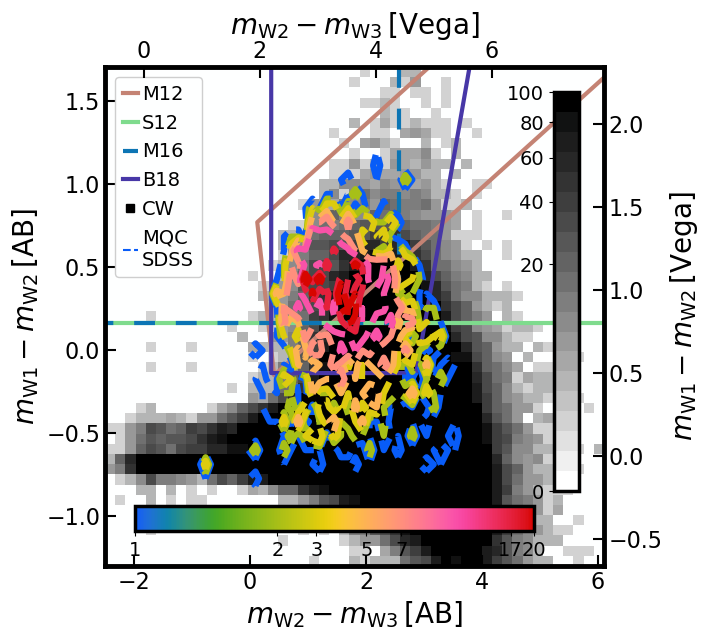

In [34]:
if not dens_clb_in:
    fig                = plt.figure(figsize=(9,6.5))
if dens_clb_in:
    fig                = plt.figure(figsize=(7.2,6.5))
ax1                = fig.add_subplot(111, xscale='linear', yscale='linear', projection='scatter_density')

num_levels_dens    = 20
cmap_dens          = 'cet_gray_r'
cmap_cont          = 'cet_CET_R3'
cmap_agn           = 'cet_CET_C9'
    
if np.sum(filt_agn_S82 & filt_plot_S82) > 0:
    if type_of_levels  == 'linear':
        contour_levels_S82 = np.linspace(0.5, 10**(np.log10(np.nanmax(dens_agn_S82.get_array()))),\
                                            num_contour_levels)
    if type_of_levels  == 'log':
        contour_levels_S82 = np.logspace(np.log10(0.5),  np.log10(np.nanmax(dens_agn_S82.get_array())),\
                                            num_contour_levels)
    contour_levels_S82[num_contour_levels - 1] -= contour_levels_S82[num_contour_levels - 1] %\
                                                    10**np.floor(np.log10(contour_levels_S82[num_contour_levels - 1]))
    contour_levels_S82 = np.unique(np.ceil(contour_levels_S82))

AB_lims_x          = (-2.5, 6.1)
AB_lims_y          = (-1.3, 1.7)

num_levels_dens = 20
cmap_dens = 'cet_gray_r'
cmap_cont = 'cet_CET_R3'
cmap_agn  = 'cet_CET_C9'

norm_val  = mcolors.CenteredNorm(vcenter=0.5)
norm_dens = ImageNormalize(vmin=0, vmax=100, stretch=PowerStretch(0.35))

if np.sum(filt_agn_S82 & filt_plot_S82) > 0:
    norm_cont      = ImageNormalize(vmin=contour_levels_S82[0], vmax=contour_levels_S82[-1], stretch=PowerStretch(0.35))

filt_bands         = np.array(full_catalog_S82_df.loc[:, 'W1mproPM']  != mag_cols_lim['W1mproPM']) &\
                     np.array(full_catalog_S82_df.loc[:, 'W2mproPM']  != mag_cols_lim['W2mproPM']) &\
                     np.array(full_catalog_S82_df.loc[:, 'W3mag']     != mag_cols_lim['W3mag'])

filt_plot          = np.isfinite(full_catalog_S82_df.loc[:, 'W2mproPM'] - full_catalog_S82_df.loc[:, 'W3mag']) &\
                     np.isfinite(full_catalog_S82_df.loc[:, 'W1mproPM'] - full_catalog_S82_df.loc[:, 'W2mproPM'])

dens_plot_data_x = (full_catalog_S82_df.loc[filt_bands, 'W2mproPM'] -\
                    full_catalog_S82_df.loc[filt_bands, 'W3mag'])[filt_plot]
dens_plot_data_y = (full_catalog_S82_df.loc[filt_bands, 'W1mproPM'] -\
                    full_catalog_S82_df.loc[filt_bands, 'W2mproPM'])[filt_plot]

dens_S82 = ax1.scatter_density(dens_plot_data_x, dens_plot_data_y,
                             cmap=plt.get_cmap(cmap_dens, num_levels_dens),
                             zorder=0, dpi=10, norm=norm_dens, alpha=1.0)

if np.sum(filt_agn_S82 & filt_plot_S82) > 0:
    xx_agn = np.linspace(dens_agn_S82.get_extent()[0],\
                         dens_agn_S82.get_extent()[1],\
                         np.shape(dens_agn_S82.get_array())[1])
    yy_agn = np.linspace(dens_agn_S82.get_extent()[2],\
                         dens_agn_S82.get_extent()[3],\
                         np.shape(dens_agn_S82.get_array())[0])

    cont_S82 = ax1.contour(xx_agn, yy_agn, np.flipud(dens_agn_S82.get_array()), levels=contour_levels_S82,\
                         linewidths=4.5, cmap=plt.get_cmap(cmap_cont), linestyles='dashed', zorder=3, norm=norm_cont)

x_Vega   = np.array(AB_lims_x) - 3.339 + 5.174  # Vega
y_Vega   = np.array(AB_lims_y) - 2.699 + 3.339  # Vega
# Mateos+2012
y_M12_a = 0.315 * (x_Vega) + 0.791
y_M12_b = 0.315 * (x_Vega) - 0.222
y_M12_c = -3.172 * (x_Vega) + 7.624
# Stern+2012
# Toba+2014
# Mingo+2016
# # Assef+2018 (75% completeness)
# y_A18_75 = 0.530 * np.exp(0.183 * (full_catalog_df.loc[filt_plot, 'W2mproPM'] - 3.339 - 13.76)**2)
# # Assef+2018 (90% completeness)
# y_A18_90 = 0.662 * np.exp(0.232 * (full_catalog_df.loc[filt_plot, 'W2mproPM'] - 3.339 - 13.97)**2)
# Blecha+2018
points_M12 = np.array([[x_Vega[-1], 1.9596, 2.2501, x_Vega[-1]], [y_M12_a[-1], 1.4083, 0.4867, y_M12_b[-1]]])
points_M16 = np.array([[4.4, 4.4, x_Vega[0], x_Vega[0]], [y_Vega[-1], 0.8, 0.8, y_Vega[-1]]])
points_B18 = np.array([[2.2, 2.2, 4.7, (y_Vega[-1] + 8.9) * 0.5], [y_Vega[-1], 0.5, 0.5, y_Vega[-1]]])

ax1.plot(points_M12[0] + 3.339 - 5.174, points_M12[1] + 2.699 - 3.339, label='M12',\
         c=plt.get_cmap(cmap_agn)(0.01), zorder=2, lw=3)
ax1.axhline(y=0.8 + 2.699 - 3.339, label='S12', c=plt.get_cmap(cmap_agn)(0.35), zorder=2, lw=3)
ax1.plot(points_M16[0] + 3.339 - 5.174, points_M16[1] + 2.699 - 3.339, label='M16',\
         c=plt.get_cmap(cmap_agn)(0.6), zorder=2, lw=3, ls=(0, (5, 5)))
ax1.plot(points_B18[0] + 3.339 - 5.174, points_B18[1] + 2.699 - 3.339, label='B18',\
         c=plt.get_cmap(cmap_agn)(0.75), zorder=2, lw=3)

ax1.plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap(cmap_dens)(1.1), label='CW', zorder=0)
if np.sum(filt_agn_S82 & filt_plot_S82) > 0:
    ax1.plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap(cmap_cont)(0.0), label='MQC\nSDSS', zorder=0)

if not dens_clb_in:
    clb = plt.colorbar(dens_S82, extend='neither', pad=0.15)
    clb.formatter.set_powerlimits((0, 0))
    clb.ax.tick_params(labelsize=14)
    clb.ax.yaxis.get_offset_text().set_fontsize(14)
    # clb.ax.yaxis.set_offset_position('right')
    clb.ax.yaxis.get_offset_text().set_position((0,0))
    clb.outline.set_linewidth(2.5)
    clb.update_ticks()
    clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2, labelpad=-2)
    ax1.set_xlim(left=AB_lims_x[0], right=AB_lims_x[1])
    ax1.set_ylim(bottom=AB_lims_y[0], top=AB_lims_y[1])
    ax1.legend(loc=2, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

# vega_shift     = {'W1mproPM': 2.699, 'W2mproPM': 3.339, 'W1mag': 2.699, 'W2mag': 3.339, 'W3mag': 5.174,\
#                   'W4mag': 6.620, 'Jmag': 0.910, 'Hmag': 1.390, 'Kmag': 1.850, 'gmag': 0.4810,\
#                     'rmag': 0.6170, 'imag': 0.7520, 'zmag': 0.8660, 'ymag': 0.9620}

# Colorbar density
if dens_clb_in:
    axins0 = inset_axes(ax1, width='100%', height='100%', bbox_transform=ax1.transAxes,\
                        loc=1, bbox_to_anchor=(0.9, 0.15, 0.05, 0.80), borderpad=0)
    
    clb_dens    = fig.colorbar(dens_S82, cax=axins0, orientation='vertical',\
                     cmap=plt.get_cmap(cmap_dens, num_levels_dens), norm=norm_dens)
    axins0.yaxis.set_ticks_position('left')
    clb_dens.ax.tick_params(labelsize=14)
    clb_dens.outline.set_linewidth(2.5)
    # clb_dens.ax.set_ylabel('Elements per pixel', size=12, path_effects=pe2)
##

# Colorbar contour
axins1 = inset_axes(ax1, width='100%', height='100%', bbox_transform=ax1.transAxes,\
                    loc=3, bbox_to_anchor=(0.06, 0.07, 0.80, 0.05), borderpad=0)
sm = plt.cm.ScalarMappable(norm=norm_cont, cmap=cont_S82.cmap)
sm.set_array([])
clb_cont    = fig.colorbar(sm, cax=axins1, orientation='horizontal', ticks=cont_S82.levels)
axins1.xaxis.set_ticks_position('bottom')
clb_cont.ax.tick_params(labelsize=14)
clb_cont.outline.set_linewidth(2.5)
##

ax1.set_xlim(AB_lims_x)
ax1.set_ylim(AB_lims_y)

ax2 = ax1.twinx()
ax2.set_ylim(tuple(np.array(ax1.get_ylim()) - 2.699 + 3.339))
ax2.tick_params(which='both', top=False, right=True, direction='in')
ax2.tick_params(which='both', bottom=False, left=False, direction='in')
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(which='major', length=8, width=1.5)
ax2.tick_params(which='minor', length=4, width=1.5)
ax2.set_ylabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[Vega]}$', size=20)

ax3 = ax1.twiny()
ax3.set_xlim(tuple(np.array(ax1.get_xlim()) - 3.339 + 5.174))
ax3.tick_params(which='both', top=True, right=False, direction='in')
ax3.tick_params(which='both', bottom=False, left=False, direction='in')
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3.tick_params(which='major', length=8, width=1.5)
ax3.tick_params(which='minor', length=4, width=1.5)
ax3.set_xlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[Vega]}$', size=20)

ax1.tick_params(which='both', top=False, right=False, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[AB]}$', size=20)
ax1.set_ylabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[AB]}$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, ncol=1, columnspacing=.5, handletextpad=0.2, handlelength=0.8, framealpha=0.95)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'W1_W2_W3_AGN_S82_{S82_subset}{imp_string}.pdf', bbox_inches='tight')
plt.show()